In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, normalize

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### On récupère les données

In [3]:
test_data = pd.read_csv('./data/exoTest.csv')
train_data = pd.read_csv('./data/exoTrain.csv')

In [4]:
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [5]:
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


### On transforme le label pour avoir des valeurs entre 0 et 1

In [6]:
label_change = {2: 1,1: 0}
train_data.LABEL = [label_change[item] for item in train_data.LABEL]
test_data.LABEL = [label_change[item] for item in test_data.LABEL]

In [7]:
train_data.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,0.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,0.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,0.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,0.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,0.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [8]:
train_data['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

In [9]:
columns = list(train_data.columns)
columns

['LABEL',
 'FLUX.1',
 'FLUX.2',
 'FLUX.3',
 'FLUX.4',
 'FLUX.5',
 'FLUX.6',
 'FLUX.7',
 'FLUX.8',
 'FLUX.9',
 'FLUX.10',
 'FLUX.11',
 'FLUX.12',
 'FLUX.13',
 'FLUX.14',
 'FLUX.15',
 'FLUX.16',
 'FLUX.17',
 'FLUX.18',
 'FLUX.19',
 'FLUX.20',
 'FLUX.21',
 'FLUX.22',
 'FLUX.23',
 'FLUX.24',
 'FLUX.25',
 'FLUX.26',
 'FLUX.27',
 'FLUX.28',
 'FLUX.29',
 'FLUX.30',
 'FLUX.31',
 'FLUX.32',
 'FLUX.33',
 'FLUX.34',
 'FLUX.35',
 'FLUX.36',
 'FLUX.37',
 'FLUX.38',
 'FLUX.39',
 'FLUX.40',
 'FLUX.41',
 'FLUX.42',
 'FLUX.43',
 'FLUX.44',
 'FLUX.45',
 'FLUX.46',
 'FLUX.47',
 'FLUX.48',
 'FLUX.49',
 'FLUX.50',
 'FLUX.51',
 'FLUX.52',
 'FLUX.53',
 'FLUX.54',
 'FLUX.55',
 'FLUX.56',
 'FLUX.57',
 'FLUX.58',
 'FLUX.59',
 'FLUX.60',
 'FLUX.61',
 'FLUX.62',
 'FLUX.63',
 'FLUX.64',
 'FLUX.65',
 'FLUX.66',
 'FLUX.67',
 'FLUX.68',
 'FLUX.69',
 'FLUX.70',
 'FLUX.71',
 'FLUX.72',
 'FLUX.73',
 'FLUX.74',
 'FLUX.75',
 'FLUX.76',
 'FLUX.77',
 'FLUX.78',
 'FLUX.79',
 'FLUX.80',
 'FLUX.81',
 'FLUX.82',
 'FLUX.83',
 'F

### On vérifie qu'il n'y a pas de données manquantes

In [10]:
print("Nombre de valeurs nulles : " + str(train_data.isnull().sum().sum()))

Nombre de valeurs nulles : 0


## Correlations

In [11]:
corrMatrix = train_data.corr()
corrMatrix['LABEL'].sort_values(ascending=False) 

LABEL        1.000000
FLUX.1611    0.023127
FLUX.1612    0.022477
FLUX.3054    0.019977
FLUX.1568    0.018600
               ...   
FLUX.2735   -0.019206
FLUX.2811   -0.020379
FLUX.2588   -0.022310
FLUX.2846   -0.023387
FLUX.2875   -0.035607
Name: LABEL, Length: 3198, dtype: float64

## Distribution des données

Text(0.5, 1.0, 'Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)')

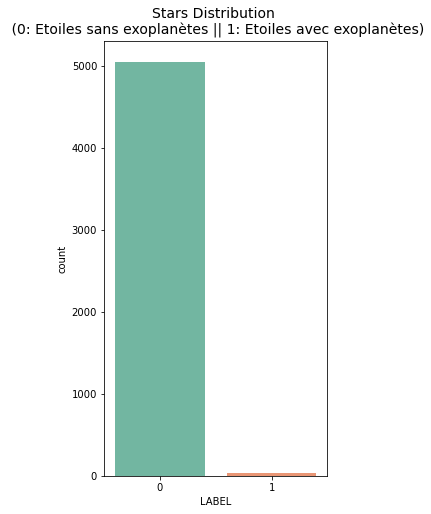

In [12]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette = "Set2")
plt.title('Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)', fontsize=14)

## Exploration des données

### On sait que les étoiles ayant potentiellement des exoplanètes en orbites autour d'elles subissent une variation de leur "flux", de leur intensité lumineuse

##### Commençons avec les étoiles ne possédant pas d'exploplanetes

In [13]:
train_data.loc[train_data['LABEL'] == 0]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,0,-141.22,-81.79,-52.28,-32.45,-1.55,-35.61,-23.28,19.45,53.11,...,-50.79,-22.34,-36.23,27.44,13.52,38.66,-17.53,31.49,31.38,50.03
38,0,-35.62,-28.55,-27.29,-28.94,-15.13,-51.06,2.67,-5.21,9.67,...,-43.98,-38.22,-46.23,-54.40,-23.51,-26.96,-3.95,-0.34,10.52,-7.69
39,0,142.40,137.03,93.65,105.64,98.22,99.06,86.40,60.78,45.18,...,-0.99,-3.03,-30.27,-24.22,-35.10,-39.64,23.78,23.40,-0.50,0.97
40,0,-167.02,-137.65,-150.05,-136.85,-98.73,-103.14,-107.70,-123.19,-125.65,...,-97.43,-79.79,-80.62,-78.22,-105.06,-69.67,-90.45,-73.67,-66.71,-66.07
41,0,207.74,223.60,246.15,224.06,210.77,189.56,172.68,170.31,148.79,...,-53.06,-136.92,-174.97,-180.46,-164.01,-126.58,84.05,63.81,108.36,78.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


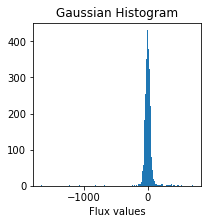

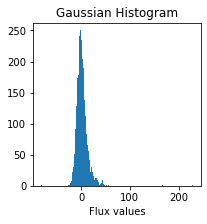

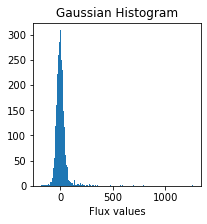

In [14]:
# On sélectionne 3 étoiles parmi les concernées (ici la ligne 37,2500 et 5086)
labels_1=[37,2500,5086]
for i in labels_1:
    plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

#### On remarque que l'intensité lumineuse de ces étoiles ne varie pas ou très peu

#### Au tour des étoiles où on sait qui possèdent des exoplanetes en orbite

In [15]:
train_data.loc[train_data['LABEL'] == 1]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,1,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,1,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,1,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,1,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,1,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


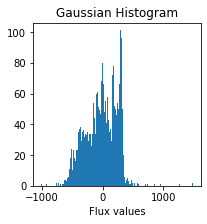

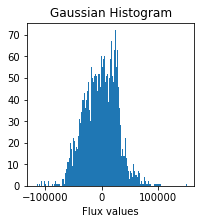

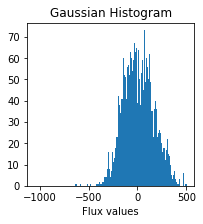

In [16]:
# On sélectionne 3 étoiles parmi les concernées (ici la ligne 0,26 et 34)
labels_1=[34,26,0]
for i in labels_1:
    plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

#### A l'inverses des étoiles n'ayant pas d'exoplanets, on observe ici une importante variation de l'intensité lumineuse

### Cependant on semble pouvoir remarquer des anomalies dans les données, on peut donc essayer de visualiser ça avec des boites à moustache

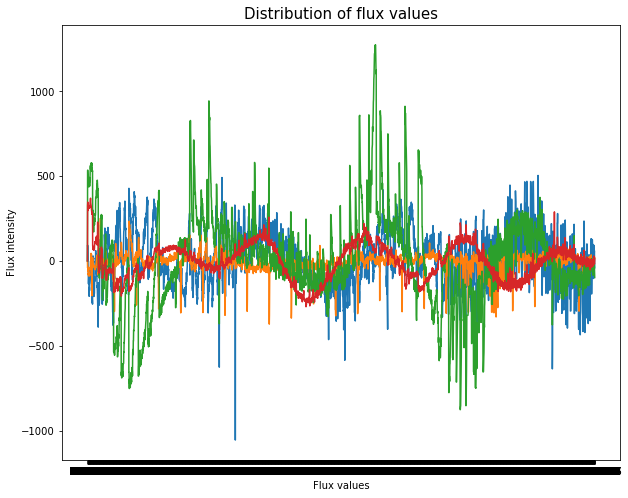

In [17]:
plt.figure(figsize=(10,8))
plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

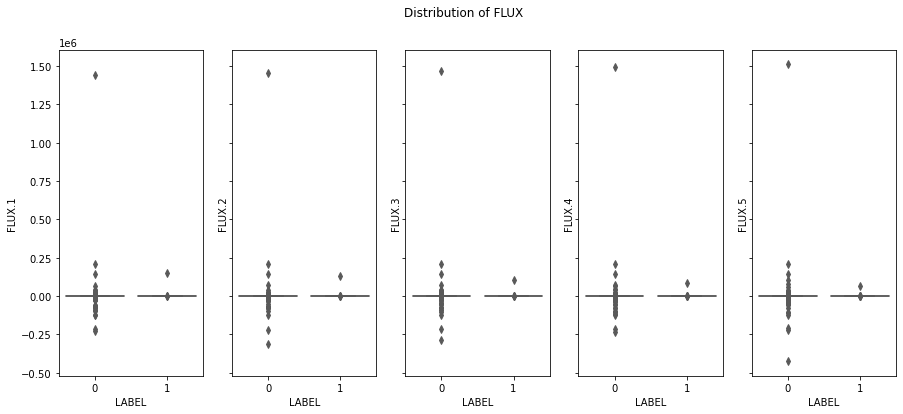

In [18]:
# green_diamond = dict(markerfacecolor='g', marker='D')
# data = [train_data.iloc[:,1], train_data.iloc[:,2], train_data.iloc[:,3]]

# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(data,vert=False, flierprops=green_diamond)

fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

#### On remarque donc des anomalies (des outliers), notamment pour les étoiles ne possédant pas d'exoplanetes, que l'on va retirer car ils peuvent perturber l'apprentissage du model plus tard

In [19]:
# Plus interessant valeur moyenne ou mediane ?

def remove_outilers(df):
    for col in df.columns:
        print("capping the ",col)
        if (col != 'LABEL'):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df
    

final = remove_outilers(train_data)

capping the  LABEL
capping the  FLUX.1
capping the  FLUX.2
capping the  FLUX.3
capping the  FLUX.4
capping the  FLUX.5
capping the  FLUX.6
capping the  FLUX.7
capping the  FLUX.8
capping the  FLUX.9
capping the  FLUX.10
capping the  FLUX.11
capping the  FLUX.12
capping the  FLUX.13


C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


capping the  FLUX.14
capping the  FLUX.15
capping the  FLUX.16
capping the  FLUX.17
capping the  FLUX.18
capping the  FLUX.19
capping the  FLUX.20
capping the  FLUX.21
capping the  FLUX.22
capping the  FLUX.23
capping the  FLUX.24
capping the  FLUX.25
capping the  FLUX.26
capping the  FLUX.27
capping the  FLUX.28
capping the  FLUX.29
capping the  FLUX.30
capping the  FLUX.31
capping the  FLUX.32
capping the  FLUX.33
capping the  FLUX.34
capping the  FLUX.35
capping the  FLUX.36
capping the  FLUX.37
capping the  FLUX.38
capping the  FLUX.39
capping the  FLUX.40
capping the  FLUX.41
capping the  FLUX.42
capping the  FLUX.43
capping the  FLUX.44
capping the  FLUX.45
capping the  FLUX.46
capping the  FLUX.47
capping the  FLUX.48
capping the  FLUX.49
capping the  FLUX.50
capping the  FLUX.51
capping the  FLUX.52
capping the  FLUX.53
capping the  FLUX.54
capping the  FLUX.55
capping the  FLUX.56
capping the  FLUX.57
capping the  FLUX.58
capping the  FLUX.59
capping the  FLUX.60
capping the  

capping the  FLUX.409
capping the  FLUX.410
capping the  FLUX.411
capping the  FLUX.412
capping the  FLUX.413
capping the  FLUX.414
capping the  FLUX.415
capping the  FLUX.416
capping the  FLUX.417
capping the  FLUX.418
capping the  FLUX.419
capping the  FLUX.420
capping the  FLUX.421
capping the  FLUX.422
capping the  FLUX.423
capping the  FLUX.424
capping the  FLUX.425
capping the  FLUX.426
capping the  FLUX.427
capping the  FLUX.428
capping the  FLUX.429
capping the  FLUX.430
capping the  FLUX.431
capping the  FLUX.432
capping the  FLUX.433
capping the  FLUX.434
capping the  FLUX.435
capping the  FLUX.436
capping the  FLUX.437
capping the  FLUX.438
capping the  FLUX.439
capping the  FLUX.440
capping the  FLUX.441
capping the  FLUX.442
capping the  FLUX.443
capping the  FLUX.444
capping the  FLUX.445
capping the  FLUX.446
capping the  FLUX.447
capping the  FLUX.448
capping the  FLUX.449
capping the  FLUX.450
capping the  FLUX.451
capping the  FLUX.452
capping the  FLUX.453
capping th

capping the  FLUX.815
capping the  FLUX.816
capping the  FLUX.817
capping the  FLUX.818
capping the  FLUX.819
capping the  FLUX.820
capping the  FLUX.821
capping the  FLUX.822
capping the  FLUX.823
capping the  FLUX.824
capping the  FLUX.825
capping the  FLUX.826
capping the  FLUX.827
capping the  FLUX.828
capping the  FLUX.829
capping the  FLUX.830
capping the  FLUX.831
capping the  FLUX.832
capping the  FLUX.833
capping the  FLUX.834
capping the  FLUX.835
capping the  FLUX.836
capping the  FLUX.837
capping the  FLUX.838
capping the  FLUX.839
capping the  FLUX.840
capping the  FLUX.841
capping the  FLUX.842
capping the  FLUX.843
capping the  FLUX.844
capping the  FLUX.845
capping the  FLUX.846
capping the  FLUX.847
capping the  FLUX.848
capping the  FLUX.849
capping the  FLUX.850
capping the  FLUX.851
capping the  FLUX.852
capping the  FLUX.853
capping the  FLUX.854
capping the  FLUX.855
capping the  FLUX.856
capping the  FLUX.857
capping the  FLUX.858
capping the  FLUX.859
capping th

capping the  FLUX.1213
capping the  FLUX.1214
capping the  FLUX.1215
capping the  FLUX.1216
capping the  FLUX.1217
capping the  FLUX.1218
capping the  FLUX.1219
capping the  FLUX.1220
capping the  FLUX.1221
capping the  FLUX.1222
capping the  FLUX.1223
capping the  FLUX.1224
capping the  FLUX.1225
capping the  FLUX.1226
capping the  FLUX.1227
capping the  FLUX.1228
capping the  FLUX.1229
capping the  FLUX.1230
capping the  FLUX.1231
capping the  FLUX.1232
capping the  FLUX.1233
capping the  FLUX.1234
capping the  FLUX.1235
capping the  FLUX.1236
capping the  FLUX.1237
capping the  FLUX.1238
capping the  FLUX.1239
capping the  FLUX.1240
capping the  FLUX.1241
capping the  FLUX.1242
capping the  FLUX.1243
capping the  FLUX.1244
capping the  FLUX.1245
capping the  FLUX.1246
capping the  FLUX.1247
capping the  FLUX.1248
capping the  FLUX.1249
capping the  FLUX.1250
capping the  FLUX.1251
capping the  FLUX.1252
capping the  FLUX.1253
capping the  FLUX.1254
capping the  FLUX.1255
capping the

capping the  FLUX.1595
capping the  FLUX.1596
capping the  FLUX.1597
capping the  FLUX.1598
capping the  FLUX.1599
capping the  FLUX.1600
capping the  FLUX.1601
capping the  FLUX.1602
capping the  FLUX.1603
capping the  FLUX.1604
capping the  FLUX.1605
capping the  FLUX.1606
capping the  FLUX.1607
capping the  FLUX.1608
capping the  FLUX.1609
capping the  FLUX.1610
capping the  FLUX.1611
capping the  FLUX.1612
capping the  FLUX.1613
capping the  FLUX.1614
capping the  FLUX.1615
capping the  FLUX.1616
capping the  FLUX.1617
capping the  FLUX.1618
capping the  FLUX.1619
capping the  FLUX.1620
capping the  FLUX.1621
capping the  FLUX.1622
capping the  FLUX.1623
capping the  FLUX.1624
capping the  FLUX.1625
capping the  FLUX.1626
capping the  FLUX.1627
capping the  FLUX.1628
capping the  FLUX.1629
capping the  FLUX.1630
capping the  FLUX.1631
capping the  FLUX.1632
capping the  FLUX.1633
capping the  FLUX.1634
capping the  FLUX.1635
capping the  FLUX.1636
capping the  FLUX.1637
capping the

capping the  FLUX.1962
capping the  FLUX.1963
capping the  FLUX.1964
capping the  FLUX.1965
capping the  FLUX.1966
capping the  FLUX.1967
capping the  FLUX.1968
capping the  FLUX.1969
capping the  FLUX.1970
capping the  FLUX.1971
capping the  FLUX.1972
capping the  FLUX.1973
capping the  FLUX.1974
capping the  FLUX.1975
capping the  FLUX.1976
capping the  FLUX.1977
capping the  FLUX.1978
capping the  FLUX.1979
capping the  FLUX.1980
capping the  FLUX.1981
capping the  FLUX.1982
capping the  FLUX.1983
capping the  FLUX.1984
capping the  FLUX.1985
capping the  FLUX.1986
capping the  FLUX.1987
capping the  FLUX.1988
capping the  FLUX.1989
capping the  FLUX.1990
capping the  FLUX.1991
capping the  FLUX.1992
capping the  FLUX.1993
capping the  FLUX.1994
capping the  FLUX.1995
capping the  FLUX.1996
capping the  FLUX.1997
capping the  FLUX.1998
capping the  FLUX.1999
capping the  FLUX.2000
capping the  FLUX.2001
capping the  FLUX.2002
capping the  FLUX.2003
capping the  FLUX.2004
capping the

capping the  FLUX.2339
capping the  FLUX.2340
capping the  FLUX.2341
capping the  FLUX.2342
capping the  FLUX.2343
capping the  FLUX.2344
capping the  FLUX.2345
capping the  FLUX.2346
capping the  FLUX.2347
capping the  FLUX.2348
capping the  FLUX.2349
capping the  FLUX.2350
capping the  FLUX.2351
capping the  FLUX.2352
capping the  FLUX.2353
capping the  FLUX.2354
capping the  FLUX.2355
capping the  FLUX.2356
capping the  FLUX.2357
capping the  FLUX.2358
capping the  FLUX.2359
capping the  FLUX.2360
capping the  FLUX.2361
capping the  FLUX.2362
capping the  FLUX.2363
capping the  FLUX.2364
capping the  FLUX.2365
capping the  FLUX.2366
capping the  FLUX.2367
capping the  FLUX.2368
capping the  FLUX.2369
capping the  FLUX.2370
capping the  FLUX.2371
capping the  FLUX.2372
capping the  FLUX.2373
capping the  FLUX.2374
capping the  FLUX.2375
capping the  FLUX.2376
capping the  FLUX.2377
capping the  FLUX.2378
capping the  FLUX.2379
capping the  FLUX.2380
capping the  FLUX.2381
capping the

capping the  FLUX.2697
capping the  FLUX.2698
capping the  FLUX.2699
capping the  FLUX.2700
capping the  FLUX.2701
capping the  FLUX.2702
capping the  FLUX.2703
capping the  FLUX.2704
capping the  FLUX.2705
capping the  FLUX.2706
capping the  FLUX.2707
capping the  FLUX.2708
capping the  FLUX.2709
capping the  FLUX.2710
capping the  FLUX.2711
capping the  FLUX.2712
capping the  FLUX.2713
capping the  FLUX.2714
capping the  FLUX.2715
capping the  FLUX.2716
capping the  FLUX.2717
capping the  FLUX.2718
capping the  FLUX.2719
capping the  FLUX.2720
capping the  FLUX.2721
capping the  FLUX.2722
capping the  FLUX.2723
capping the  FLUX.2724
capping the  FLUX.2725
capping the  FLUX.2726
capping the  FLUX.2727
capping the  FLUX.2728
capping the  FLUX.2729
capping the  FLUX.2730
capping the  FLUX.2731
capping the  FLUX.2732
capping the  FLUX.2733
capping the  FLUX.2734
capping the  FLUX.2735
capping the  FLUX.2736
capping the  FLUX.2737
capping the  FLUX.2738
capping the  FLUX.2739
capping the

capping the  FLUX.3071
capping the  FLUX.3072
capping the  FLUX.3073
capping the  FLUX.3074
capping the  FLUX.3075
capping the  FLUX.3076
capping the  FLUX.3077
capping the  FLUX.3078
capping the  FLUX.3079
capping the  FLUX.3080
capping the  FLUX.3081
capping the  FLUX.3082
capping the  FLUX.3083
capping the  FLUX.3084
capping the  FLUX.3085
capping the  FLUX.3086
capping the  FLUX.3087
capping the  FLUX.3088
capping the  FLUX.3089
capping the  FLUX.3090
capping the  FLUX.3091
capping the  FLUX.3092
capping the  FLUX.3093
capping the  FLUX.3094
capping the  FLUX.3095
capping the  FLUX.3096
capping the  FLUX.3097
capping the  FLUX.3098
capping the  FLUX.3099
capping the  FLUX.3100
capping the  FLUX.3101
capping the  FLUX.3102
capping the  FLUX.3103
capping the  FLUX.3104
capping the  FLUX.3105
capping the  FLUX.3106
capping the  FLUX.3107
capping the  FLUX.3108
capping the  FLUX.3109
capping the  FLUX.3110
capping the  FLUX.3111
capping the  FLUX.3112
capping the  FLUX.3113
capping the

#### On vérifie avec les memes données que précédemment et on constate qu'on a bien remplacé les données abberantes

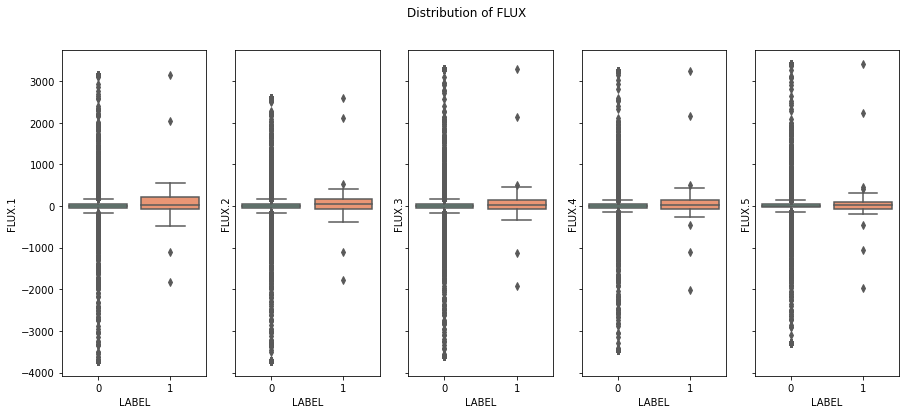

In [20]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

In [21]:
final

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


# Préparation et entrainement du model

#### On va split le dataset pour travailler dessus et préparer le model

In [22]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Données très disproportionnée : pas assez d'étoiles avec des éxoplanètes pour avoir de bons résultats (37 avec contre 5050 sans) 

#### On va donc mettre en place un SMOTE

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# X = X_train

# smote = SMOTE(random_state=0)
# X_train, y_train = smote.fit_sample(X, y_train)

In [ ]:
model = SMOTE()
ov_train_x,ov_train_y = model.fit_sample(train_data.drop('LABEL',axis=1), train_data['LABEL'])
ov_train_y = ov_train_y.astype('int')

In [25]:
pd.Series(y_train).value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

In [26]:
X_train.shape

(5087, 3197)

In [27]:
y_train.shape

(5087,)

In [28]:
X_test.shape

(570, 3197)

## Normalisation de la donnée

#### On va normaliser les données pour la préparer pour le machine learning. L'idée est d'organiser toutes les données dans un même fourchette pour faciliter l'apprentissage (tout en gardant les ordres de grandeur)

In [29]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
# Lui applique les filtres gaussians a des données numériques ==> interet ???

In [30]:
#Feature scaling
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [ ]:
# fig = plt.figure(figsize=(16, 16))

# plt.scatter(x=X_train[0:10100,1], y=X_train[0:10100,2], c=y_train[0:10100], edgecolors='red' )
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)

# ANN

In [31]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,X_train.shape[1])),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,X_train.shape[1])),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
model10.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [34]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.001)

In [35]:
model11.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [36]:
history = model10.fit(X_train,
                      y_train,
                      validation_split=0.2,
                    epochs=200,
                    batch_size= 40)
#                     ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10),
#                                tfdocs.modeling.EpochDots(),
#                                tf.keras.callbacks.ModelCheckpoint("weights.best.hdf5", 
#                                                                    monitor='accuracy', 
#                                                                    verbose=0, 
#                                                                    save_best_only=True, 
#                                                                    save_weights_only=False, 
#                                                                    mode='max', 
#                                                                    periode=1)])

Epoch 1/200
102/102 [==============================] - 1s 6ms/step - loss: 0.1591 - accuracy: 0.9634 - val_loss: 0.0544 - val_accuracy: 0.9990
Epoch 2/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0620 - accuracy: 0.9929 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 3/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0449 - accuracy: 0.9958 - val_loss: 0.0418 - val_accuracy: 0.9990
Epoch 4/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0386 - accuracy: 0.9971 - val_loss: 0.0373 - val_accuracy: 0.9980
Epoch 5/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9971 - val_loss: 0.0384 - val_accuracy: 0.9980
Epoch 6/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.9975 - val_loss: 0.0326 - val_accuracy: 0.9990
Epoch 7/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0238 - accuracy: 0.9985 - val_loss: 0.0324 - val_accuracy: 0.9990

102/102 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0124 - val_accuracy: 0.9961
Epoch 54/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0145 - val_accuracy: 0.9961
Epoch 55/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0123 - val_accuracy: 0.9971
Epoch 56/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0174 - val_accuracy: 0.9941
Epoch 57/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0142 - val_accuracy: 0.9961
Epoch 58/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0113 - val_accuracy: 0.9971
Epoch 59/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0149 - val_accuracy: 0.9961
Epoch

Epoch 110/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0196 - val_accuracy: 0.9921
Epoch 111/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0225 - val_accuracy: 0.9921
Epoch 112/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0197 - val_accuracy: 0.9931
Epoch 113/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0156 - val_accuracy: 0.9951
Epoch 114/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0153 - val_accuracy: 0.9951
Epoch 115/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0156 - val_accuracy: 0.9941
Epoch 116/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0161 - val_ac

Epoch 166/200
102/102 [==============================] - 0s 4ms/step - loss: 4.5414e-04 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9921
Epoch 167/200
102/102 [==============================] - 0s 4ms/step - loss: 4.5099e-04 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9902
Epoch 168/200
102/102 [==============================] - 0s 4ms/step - loss: 5.3122e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9912
Epoch 169/200
102/102 [==============================] - 0s 4ms/step - loss: 4.3860e-04 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9912
Epoch 170/200
102/102 [==============================] - 0s 4ms/step - loss: 4.2354e-04 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9902
Epoch 171/200
102/102 [==============================] - 0s 4ms/step - loss: 4.1230e-04 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9912
Epoch 172/200
102/102 [==============================] - 0s 4ms/step - loss: 4.0966e-04 - accuracy: 1.0000

In [37]:
history2 = model11.fit(X_train,
                      y_train,
                      validation_split=0.2,
                    epochs=100,
                    batch_size= 40)

Epoch 1/100
102/102 [==============================] - 0s 5ms/step - loss: 0.2215 - accuracy: 0.9182 - val_loss: 0.0657 - val_accuracy: 0.9833
Epoch 2/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9926 - val_loss: 0.0654 - val_accuracy: 0.9813
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0177 - accuracy: 0.9963 - val_loss: 0.0529 - val_accuracy: 0.9862
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.0423 - val_accuracy: 0.9872
Epoch 5/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.0406 - val_accuracy: 0.9882
Epoch 6/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0113 - accuracy: 0.9995 - val_loss: 0.0416 - val_accuracy: 0.9872
Epoch 7/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0357 - val_accuracy: 0.9872

Epoch 53/100
102/102 [==============================] - 0s 4ms/step - loss: 8.7687e-04 - accuracy: 0.9993 - val_loss: 0.0202 - val_accuracy: 0.9912
Epoch 54/100
102/102 [==============================] - 0s 4ms/step - loss: 4.3630e-04 - accuracy: 0.9998 - val_loss: 0.0199 - val_accuracy: 0.9912
Epoch 55/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0193 - val_accuracy: 0.9912
Epoch 56/100
102/102 [==============================] - 0s 4ms/step - loss: 5.3794e-04 - accuracy: 0.9998 - val_loss: 0.0192 - val_accuracy: 0.9912
Epoch 57/100
102/102 [==============================] - 0s 4ms/step - loss: 4.7686e-04 - accuracy: 0.9998 - val_loss: 0.0202 - val_accuracy: 0.9912
Epoch 58/100
102/102 [==============================] - 0s 5ms/step - loss: 5.5126e-04 - accuracy: 0.9995 - val_loss: 0.0201 - val_accuracy: 0.9912
Epoch 59/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.

In [38]:
# ax2 = train_data.plot.scatter(x='LABEL',
#                       y='FLUX.1',
#                       colormap='viridis')

In [39]:
predict_model10 = model10.predict(X_train)
predict_model11 = model11.predict(X_train)

rounded_predictions = np.argmax(predict_model10, axis=-1)
rounded_predictions2 = np.argmax(predict_model11, axis=-1)


cm = confusion_matrix(y_train, y_pred=rounded_predictions)
cm2 = confusion_matrix(y_train, y_pred=rounded_predictions)

cm2

array([[5050,    0],
       [  37,    0]], dtype=int64)

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, rounded_predictions))

0.9927265578926676


In [41]:
model_test = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='tanh', input_shape=(1,X_train.shape[1])),
    tf.keras.layers.Dense(30, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(10, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model_test.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [43]:
history = model_test.fit(X_train,
                      y_train,
                      validation_split=0.2,
                    epochs=200,
                    batch_size= 40)

Epoch 1/200
102/102 [==============================] - 1s 6ms/step - loss: 0.2372 - accuracy: 0.9646 - val_loss: 0.0588 - val_accuracy: 1.0000
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1745 - accuracy: 0.9909 - val_loss: 0.0519 - val_accuracy: 1.0000
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1748 - accuracy: 0.9870 - val_loss: 0.0821 - val_accuracy: 0.9921
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9899 - val_loss: 0.0621 - val_accuracy: 1.0000
Epoch 5/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1627 - accuracy: 0.9919 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 6/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1555 - accuracy: 0.9916 - val_loss: 0.0633 - val_accuracy: 0.9961
Epoch 7/200
102/102 [==============================] - 1s 5ms/step - loss: 0.1451 - accuracy: 0.9924 - val_loss: 0.0738 - val_accuracy: 0.9971

Epoch 53/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9948 - val_loss: 0.0343 - val_accuracy: 0.9941
Epoch 54/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0881 - accuracy: 0.9946 - val_loss: 0.0319 - val_accuracy: 0.9951
Epoch 55/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0873 - accuracy: 0.9948 - val_loss: 0.0319 - val_accuracy: 0.9961
Epoch 56/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0873 - accuracy: 0.9946 - val_loss: 0.0326 - val_accuracy: 0.9961
Epoch 57/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9943 - val_loss: 0.0274 - val_accuracy: 0.9971
Epoch 58/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0854 - accuracy: 0.9946 - val_loss: 0.0310 - val_accuracy: 0.9931
Epoch 59/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0846 - accuracy: 0.9946 - val_loss: 0.0248 - val_accuracy:

Epoch 110/200
102/102 [==============================] - 0s 4ms/step - loss: 0.1018 - accuracy: 0.9936 - val_loss: 0.0379 - val_accuracy: 0.9902
Epoch 111/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1016 - accuracy: 0.9936 - val_loss: 0.0378 - val_accuracy: 0.9902
Epoch 112/200
102/102 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9936 - val_loss: 0.0377 - val_accuracy: 0.9902
Epoch 113/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1014 - accuracy: 0.9936 - val_loss: 0.0371 - val_accuracy: 0.9902
Epoch 114/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1013 - accuracy: 0.9936 - val_loss: 0.0373 - val_accuracy: 0.9902
Epoch 115/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9939 - val_loss: 0.0372 - val_accuracy: 0.9902
Epoch 116/200
102/102 [==============================] - 0s 5ms/step - loss: 0.1011 - accuracy: 0.9939 - val_loss: 0.0369 - val_ac

In [44]:
predict_model_test = model_test.predict(X_test)

rounded_predictions_test = np.argmax(predict_model_test, axis=-1)

cm = confusion_matrix(y_test, y_pred=rounded_predictions_test)

print(cm)

print(classification_report(y_test, rounded_predictions_test, zero_division=1))

[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       1.00      0.50      0.50       570
weighted avg       0.99      0.99      0.99       570



In [47]:
from sklearn.model_selection import train_test_split 

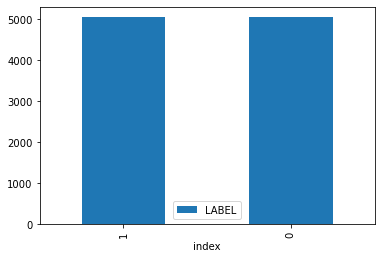

In [45]:
from imblearn.over_sampling import SMOTE
model = SMOTE()
ov_train_x,ov_train_y = model.fit_sample(train_data.drop('LABEL',axis=1), train_data['LABEL'])
ov_train_y = ov_train_y.astype('int')

ov_train_y.value_counts().reset_index().plot(kind='bar', x='index', y='LABEL')

In [48]:
train_X, test_X, train_y, test_y = train_test_split(ov_train_x, ov_train_y, test_size=0.33, random_state=42)

In [51]:
model_after_smote = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,X_train.shape[1])),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
model_after_smote.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [53]:
history_after_smote = model_after_smote.fit(train_X,
                      train_y,
                      validation_split=0.2,
                    epochs=100,
                    batch_size= 40)

Epoch 1/100
136/136 [==============================] - 1s 5ms/step - loss: 165.6572 - accuracy: 0.8587 - val_loss: 15.4888 - val_accuracy: 0.9439
Epoch 2/100
136/136 [==============================] - 1s 4ms/step - loss: 3.8791 - accuracy: 0.9747 - val_loss: 21.4614 - val_accuracy: 0.9542
Epoch 3/100
136/136 [==============================] - 1s 4ms/step - loss: 5.6150 - accuracy: 0.9780 - val_loss: 25.1968 - val_accuracy: 0.9727
Epoch 4/100
136/136 [==============================] - 1s 4ms/step - loss: 1.2539 - accuracy: 0.9885 - val_loss: 4.6975 - val_accuracy: 0.9867
Epoch 5/100
136/136 [==============================] - 1s 4ms/step - loss: 0.4815 - accuracy: 0.9946 - val_loss: 4.5761 - val_accuracy: 0.9911
Epoch 6/100
136/136 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.9952 - val_loss: 5.9486 - val_accuracy: 0.9830
Epoch 7/100
136/136 [==============================] - 1s 4ms/step - loss: 4.9247 - accuracy: 0.9887 - val_loss: 4.7902 - val_accuracy: 0

In [54]:
predict_model_test_after_smote = model_test.predict(test_X)

rounded_predictions_test_after_smote = np.argmax(predict_model_test_after_smote, axis=-1)

cm_af_smote = confusion_matrix(test_y, y_pred=rounded_predictions_test_after_smote)

print(cm_af_smote)

[[1700    0]
 [1633    0]]


In [63]:
model_DT_smote = DecisionTreeClassifier(max_features=19, random_state=0)

In [64]:
scores = cross_val_score(model_DT_smote, train_X, train_y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

scores [0.18828308 0.22078148 0.18033393 0.21918346 0.21578506]
moyenne 0.204873400788737
ecart type 0.017054815756419563


In [66]:
model_DT_smote.fit(train_X, train_y)
print(model_DT_smote.__class__.__name__, model_DT_smote.score(test_X, test_y))
print(confusion_matrix(test_y, model_DT_smote.predict(test_X)))

DecisionTreeClassifier 0.9654965496549655
[[1608   92]
 [  23 1610]]


## Courbe d'apprentissage

In [ ]:
def learning_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
learning_curve(history)

In [ ]:
learning_curve(history2)

In [ ]:
# fig = plt.figure(figsize=(16, 16))

# plt.scatter(x=X_train[0:10100,1], y=X_train[0:10100,2], c=y_train[0:10100], edgecolors='red' )

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# test scatter plot

# plt.scatter(history.history['accuracy'],history.history['loss'])

# plt.title('Nuage de points avec Matplotlib')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.ylabel('y')

# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Evaluation du modele CNN

In [ ]:
test_loss, test_acc = model10.evaluate(X_test,y_test)

In [ ]:
test_loss, test_acc = model11.evaluate(X_test,y_test)

In [ ]:
## 99% ça semble bizarre ==> vérifier si pas oublié une/des étapes

In [ ]:
pd.Series(y_test).value_counts()

In [ ]:


predict_model10 = model10.predict(X_test)
predict_model11 = model11.predict(X_test)

rounded_predictions = np.argmax(predict_model10, axis=-1)
rounded_predictions2 = np.argmax(predict_model11, axis=-1)


cm = confusion_matrix(y_test, y_pred=rounded_predictions)
cm2 = confusion_matrix(y_test, y_pred=rounded_predictions)

cm2
# confusion_matrix(y_test, predict2)

### En effet il est incapable de détecter les étoiles possédant des exoplanètes et met tout à 0

In [ ]:
predict_model10 = model10.predict(X_train)
predict_model11 = model11.predict(X_train)

rounded_predictions = np.argmax(predict_model10, axis=-1)
rounded_predictions2 = np.argmax(predict_model11, axis=-1)


cm = confusion_matrix(y_train, y_pred=rounded_predictions)
cm2 = confusion_matrix(y_train, y_pred=rounded_predictions)

cm2

print(classification_report(y_train, rounded_predictions, zero_division=1))

In [ ]:
predict_model10 = model10.predict(X_test)
predict_model11 = model11.predict(X_test)

rounded_predictions = np.argmax(predict_model10, axis=-1)
rounded_predictions2 = np.argmax(predict_model11, axis=-1)


cm = confusion_matrix(y_test, y_pred=rounded_predictions)
cm2 = confusion_matrix(y_test, y_pred=rounded_predictions2)

print(cm)

print(classification_report(y_test, rounded_predictions, zero_division=1))

# Modèles

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Validation Croisée

In [58]:
from sklearn.model_selection import cross_val_score

In [59]:
def display_scores(scores):
    print('scores',scores),
    print('moyenne',scores.mean())
    print('ecart type',scores.std())

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def display_grid(grid):
    cvr = grid.cv_results_
    for mean_score, params in zip(cvr['mean_test_score'], cvr['params']):
        print(np.sqrt(-mean_score), params)

## DecisionTree

In [ ]:
model_DT = DecisionTreeClassifier(max_features=19, random_state=0)

In [ ]:
scores = cross_val_score(model_DT, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

In [ ]:
param_grid = {'max_features':np.arange(4,20)}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
display_grid(grid)

In [ ]:
model_DT.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_DT.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT.predict(X_test)))

## KNN

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=8, metric='manhattan', n_jobs=-1)

In [ ]:
scores = cross_val_score(model_KNN, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

In [ ]:
param_grid = {'n_neighbors':np.arange(7,10),
             'metric':['euclidean','manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=10)
grid.fit(X_train, y_train)
print(grid.best_params_)
display_grid(grid)

In [ ]:
model_KNN.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_KNN.score(X_test, y_test))
print(confusion_matrix(y_test, model_KNN.predict(X_test)))

## Voting classifier

In [ ]:
for model in (model_DT, 
              model_KNN):
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))
    print(confusion_matrix(y_test, model.predict(X_test)))
    
# print('model10')
# model10.fit(X_train, y_train)

In [ ]:
# https://python4astronomers.github.io/astropy/fits.html
    
# Récupérer données d'une des campagne de k2 ==> récup fichier fits/ouvrir/lire/recupérer flux et tester

In [ ]:
from astropy.io import fits
from astropy.table import Table

In [ ]:
hdulist = fits.open('./data/ktwo200006425-c04_llc.fits')

In [ ]:
hdulist.info()

In [ ]:
hdu = hdulist[0]
hdu.header

In [ ]:
hdulist2 = fits.open('data/ktwo200252206-c19_llc.fits')
hdulist2.info()

In [ ]:
hdu = hdulist[0]
hdu.header

In [ ]:
hdu2 = hdulist[1]
hdu2.header
# hdu2.data.shape

In [ ]:
# hdu2.

In [ ]:
hdu3 = hdulist[1]
hdu3.header
# hdu3.data.shape

In [ ]:
dat = Table.read('data/ktwo200006425-c04_llc.fits', format='fits')
df = dat.to_pandas()

df

In [ ]:
ax2 = df.plot.scatter(x='TIME',
                      y='SAP_FLUX',
                      colormap='viridis')

In [ ]:
fig.suptitle('Distribution of FLUX')

sns.boxplot(y=df["SAP_FLUX"])


In [ ]:
data_df = []

for ind in df.index:
    data_df.append(df['SAP_FLUX'][ind])

data_df   


In [ ]:
df_test = pd.DataFrame(data_df) 
df_test

In [ ]:
print("Nombre de valeurs nulles : " + str(df_test.isnull().sum().sum()))

In [ ]:
df_test = df_test.dropna()

In [ ]:
print("Nombre de valeurs nulles : " + str(df_test.isnull().sum().sum()))

In [ ]:
df_test.shape

#### On a plus d'info que de l'autre coté, on va donc réduire à 3197 lignes

In [ ]:
df_test= df_test[0:3197]

In [ ]:
df_test.shape

In [ ]:

def survie(model,df):
    x = np.array(df[0]).reshape(1,3197)
    print(model.predict(x))
    
survie(model10, df_test)

In [ ]:
#test prediction

def isexoplanet(model, df):
    print(model.predict(df))
    print(model.predict_proba(df))
    
isexoplanet(model10, df_test)

In [ ]:
dat2 = Table.read('data/ktwo_anc-eng_ADATTERRX.fits', format='fits')
df2 = dat2.to_pandas()

df2

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[10,])
plt.plot(train_data.iloc[11,])
plt.plot(train_data.iloc[12,])
plt.plot(train_data.iloc[13,])
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr())
plt.title('Correlation in the data')
plt.show()